In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import random_split
from torchvision import transforms
from PIL import Image
import lightning as L

In [2]:
def rinomina_immagini(cartella_immagini):
    # Estensioni delle immagini supportate
    estensioni_supportate = (".jpg", ".jpeg", ".png", ".bmp", ".gif")

    # Legge tutti i file nella cartella
    file_immagini = [f for f in os.listdir(cartella_immagini) if f.lower().endswith(estensioni_supportate)]

    # Ordina i file per nome (opzionale)
    file_immagini.sort()

    # Rinomina le immagini
    for i, nome_file in enumerate(file_immagini):
        estensione = os.path.splitext(nome_file)[1]  # Ottieni l'estensione
        nuovo_nome = f"{i+1}{estensione}"  # Nuovo nome sequenziale
        percorso_vecchio = os.path.join(cartella_immagini, nome_file)
        percorso_nuovo = os.path.join(cartella_immagini, nuovo_nome)
        
        # Rinomina il file
        os.rename(percorso_vecchio, percorso_nuovo)

In [3]:
#rinomina_immagini('data/segmentation_full_body_mads_dataset_1192_img/images')
#rinomina_immagini('data/segmentation_full_body_mads_dataset_1192_img/masks')

In [70]:


class SegmentationImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None, target_transform=None):
        self.img_labels = label_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_labels))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f'{idx+1}.png')
        image = read_image(img_path)
        label_path = os.path.join(self.img_labels, f'{idx+1}.png')
        label = read_image(label_path)[:][:][0].unsqueeze(0)
        label = label/ 255
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

transform_img = transforms.Compose([
    transforms.Resize((500, 500)),  # Ridimensiona l'immagine
    transforms.Lambda(lambda x: x.float())  
])

transform_label = transforms.Compose([
    transforms.Resize((500, 500)),  # Ridimensiona l'immagine
    transforms.Lambda(lambda x: x.float()),
    transforms.Grayscale(num_output_channels=1)
])


In [71]:
data = SegmentationImageDataset('data/segmentation_full_body_mads_dataset_1192_img/images', 'data/segmentation_full_body_mads_dataset_1192_img/masks', transform_img, transform_label)

In [72]:
data[0][0].shape, data[0][1].shape

(torch.Size([3, 500, 500]), torch.Size([1, 500, 500]))

In [73]:
train, val, test = random_split(data, [0.5, 0.2, 0.3])

In [74]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test, batch_size=8, shuffle=True)

In [ ]:


class UnetEncoder(torch.nn.Module):
  def __init__(self, in_channel, num_filters):
    super().__init__()

    # layer convolutivo con 10 filtri 5x5
    self.conv1 = torch.nn.Conv2d(in_channel, num_filters, (3,3), padding='valid')
    self.conv2 = torch.nn.Conv2d(num_filters, num_filters, (3,3), padding='valid')
    self.pool = torch.nn.MaxPool2d(2, (2,2))


  def forward(self, x):
    x = self.conv1(x)
    x = torch.nn.functional.relu(x)

    x = self.conv2(x)
    x = torch.nn.functional.relu(x)
    
    x = self.pool(x)

    return x
  


class UnetDecoder(torch.nn.Module):
  def __init__(self, in_channel, num_filters):
    super().__init__()

  
    self.tconv1 = torch.nn.ConvTranspose2d(in_channel, num_filters, (2,2), stride=2)



    
    self.conv1 = torch.nn.Conv2d(in_channel, num_filters, (3,3), padding='valid')
    self.conv2 = torch.nn.Conv2d(num_filters, num_filters, (3,3), padding='valid')



  def forward(self, x, skip_conn):

    x = self.tconv1(x)

    skip_conn = torchvision.transforms.functional.crop(skip_conn, 0, 0, x.shape[2], x.shape[3])


    x = torch.cat([x, skip_conn], dim=1)



    x = self.conv1(x)
    x = torch.nn.functional.relu(x)

    x = self.conv2(x)
    x = torch.nn.functional.relu(x)

    return x
  





class Unet(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.enc1 = UnetEncoder(3,64)
    self.enc2 = UnetEncoder(64,128)
    self.enc3 = UnetEncoder(128,256)
    self.enc4 = UnetEncoder(256,512)
    
    self.bot_conv1 = torch.nn.Conv2d(512,1024, (3,3), padding='valid')
    self.bot_conv2 = torch.nn.Conv2d(1024,1024, (3,3), padding='valid')

    
    self.dec1 = UnetDecoder(64*2, 64)
    self.dec2 = UnetDecoder(128*2, 128)
    self.dec3 = UnetDecoder(256*2, 256)
    self.dec4 = UnetDecoder(512*2, 512)

    self.conv_final = torch.nn.Conv2d(64, 1, (1,1), padding='valid')
  
  def forward(self, x):
    e1 = self.enc1.forward(x)
    e2 = self.enc2.forward(e1)
    e3 = self.enc3.forward(e2)
    e4 = self.enc4.forward(e3)


    x = self.bot_conv1(e4)
    x = torch.nn.functional.relu(x)

    x = self.bot_conv2(x)
    x = torch.nn.functional.relu(x)

    d4 = self.dec4.forward(x, e4)
    d3 = self.dec3.forward(d4, e3)
    d2 = self.dec2.forward(d3, e2)
    d1 = self.dec1.forward(d2, e1)

    x = self.conv_final(d1)

    return x
  



# define the LightningModule
class LitUnet(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = Unet()

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        y_pred = self.net(x)
        y_pred = torchvision.transforms.functional.resize(y_pred, (y.shape[2], y.shape[3]))
        loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred, y)

        y_pred_bin = (torch.sigmoid(y_pred) > 0.5).float()

        # Calcola l'accuratezza pixel-wise
        accuracy = (y_pred_bin == y).float().mean()
        
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy)
        return loss
    
    def validation_step(self, batch, batch_idx):
       # this is the test loop
        x, y = batch
        y_pred = self.net(x)
        y_pred = torchvision.transforms.functional.resize(y_pred, (y.shape[2], y.shape[3]))
        loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred, y)
        
        y_pred_bin = (torch.sigmoid(y_pred) > 0.5).float()

        # Calcola l'accuratezza pixel-wise
        accuracy = (y_pred_bin == y).float().mean()

        # Log della loss e dell'accuratezza
        self.log("val_loss", loss)
        self.log("val_accuracy", accuracy)

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        y_pred = self.net(x)
        y_pred = torchvision.transforms.functional.resize(y_pred, (y.shape[2], y.shape[3]))
        loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred, y)
        
        y_pred_bin = (torch.sigmoid(y_pred) > 0.5).float()

        # Calcola l'accuratezza pixel-wise
        accuracy = (y_pred_bin == y).float().mean()

        # Log della loss e dell'accuratezza
        self.log("test_loss", loss)
        self.log("test_accuracy", accuracy)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer




In [87]:
from pytorch_lightning.loggers import CSVLogger

In [ ]:
model = LitUnet()
csv_logger = CSVLogger("logs", name="unet")
trainer = L.Trainer(max_epochs=1, max_steps=3, log_every_n_steps=5, logger=csv_logger)
trainer.fit(model=model, train_dataloaders=train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode 
--------------------------------------
0 | net  | Unet | 31.0 M | train
--------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.127   Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=3` reached.


In [89]:
model.eval()
a = model.net.forward(train[2][0].unsqueeze(0))

In [90]:
a.shape

torch.Size([1, 1, 308, 308])

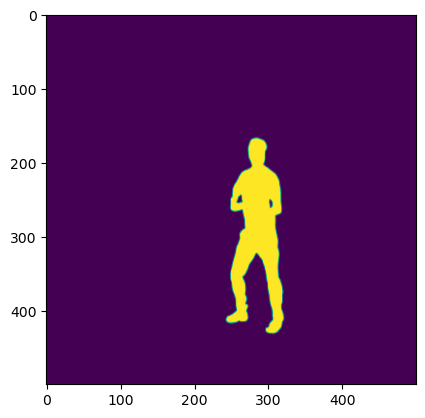

In [93]:
plt.imshow(train[2][1].permute(1,2,0))

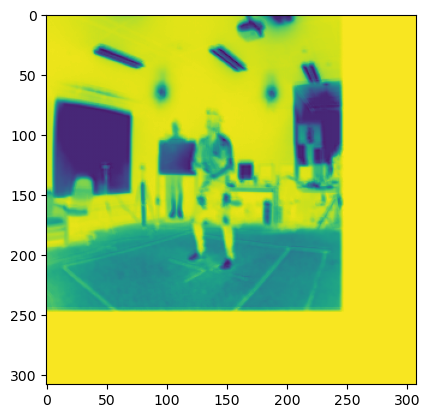

In [92]:
plt.imshow(a.detach()[0].permute(1,2,0))